In [25]:
# removes annoying deprecation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
from google.cloud import bigquery
from bq_helper import BigQueryHelper #third party library to translate google query data to dataframe
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os, sys

sys.path.insert(0, './../utils/')

# custom files 
import random_forest_regressor as rfr
import utilities as util
import validation as cv
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import train_test_split
from sklearn import cross_validation

%matplotlib inline

with open('../../key.txt') as f:
    content = f.readlines()

#add your own key here 
os.environ['GOOGLE_APPLICATION_CREDENTIALS']= content[0]

In [26]:
EPA_VISUAL = """
        SELECT
            avg(arithmetic_mean) as am,
            EXTRACT(YEAR FROM PPM25_daily.date_local)*100 +
            EXTRACT(MONTH FROM PPM25_daily.date_local) as date
        FROM
          `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary` as PPM25_daily
        WHERE state_name ="California" AND city_name="San Francisco"
        GROUP BY date
        ORDER BY date DESC
        """
bq_assistant_PPM = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_PPM_VISUAL = bq_assistant_PPM.query_to_pandas(EPA_VISUAL)

In [27]:
df_PPM_VISUAL['formatted_date'] = pd.to_datetime(df_PPM_VISUAL['date'], format='%Y%m')
df_PPM_VISUAL.head()

,am,date,formatted_date
0,17.572744,201712,2017-12-01
1,9.228025,201711,2017-11-01
2,16.053566,201710,2017-10-01
3,14.286595,201709,2017-09-01
4,8.574398,201708,2017-08-01


Text(0.5,1,'PPM 2.5 arithmetic mean between 1999 & 2017')

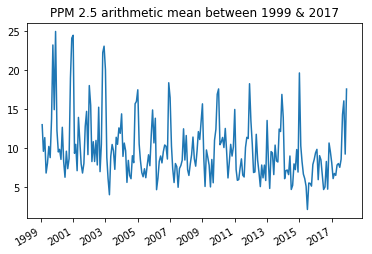

In [28]:
# plot original data 
fig, ax = plt.subplots()
ax.plot(df_PPM_VISUAL['formatted_date'], df_PPM_VISUAL['am'])
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
# n = 20
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
ax.set_title('PPM 2.5 arithmetic mean between 1999 & 2017')

In [29]:
EPA_QUERY = """
        SELECT
            avg(arithmetic_mean) as am,
            EXTRACT(YEAR FROM PPM25_daily.date_local)*10000 +
            EXTRACT(MONTH FROM PPM25_daily.date_local)*100 + 
            EXTRACT(DAY FROM PPM25_daily.date_local) as date
        FROM
          `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary` as PPM25_daily
        WHERE state_name ="California" AND city_name="San Francisco"
        GROUP BY date
        ORDER BY date DESC
        """

bq_assistant_PPM = BigQueryHelper("bigquery-public-data", "epa_historical_air_quality")
df_PPM = bq_assistant_PPM.query_to_pandas(EPA_QUERY)

In [30]:
df_PPM.head()

,am,date
0,19.112500,20171231
1,20.929167,20171230
2,22.745833,20171229
3,16.725000,20171228
4,18.204166,20171227


In [31]:
# find optimum regressor
regr = rfr.find_regressor(df_PPM['date'].as_matrix().reshape(-1,1), df_PPM['am'].values)
regr

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/kristina/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV] n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.1s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.1s
[CV] n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=250, min_samples_split=8, max_depth=50, bootstrap=True, total=   1.2s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_depth=80, bootstrap=True, total=   1.4s
[CV] n_estimators=250, min_samples_split=2, max_depth=10, bootstrap=False 
[CV]  n_estimators=275, min_samples_split=4, max_d

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.6s finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [32]:
# split dataset 
X_train, X_test, y_train, y_test = train_test_split(df_PPM['date'].to_frame(), df_PPM['am'].values, test_size=0.33, random_state=42)
# make predictions based on optimum regressor
y_pred = rfr.fit_and_predict(regr, X_train, X_test, y_train, y_test)

./../utils/random_forest_regressor.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  regr.fit(X_train.as_matrix(), y_train)
./../utils/random_forest_regressor.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return regr.predict(X_test.as_matrix())


In [33]:
cv.MSE(y_test, y_pred)

45.64918194028494

In [34]:
tss_score = cv.Cross_Validation(df_PPM['date'].to_frame(), df_PPM['am'], regr, 10)
print('10-fold cross validation using time series split (additive): {} '.format(tss_score))

10-fold cross validation using time series split (additive): 85.31698434324686 
